In [23]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import random

### Parâmetros

In [65]:
d = 30
tamanho_pop = 50
qte_filhos = 350
max_geracoes = 500
learning_rate = 0.1

### Funções de fitness

In [4]:
def ackley(x):
    if isinstance(x, list):
      x = np.array(x)
    a = 20
    b = 0.2
    c = 2 * np.pi
    term1 = -a * np.exp(-b * np.sqrt(np.sum(x**2) / d))
    term2 = -np.exp(np.sum(np.cos(c * x)) / d)
    return term1 + term2 + a + np.exp(1)

In [5]:
def rastrigin(x):
    if isinstance(x, list):
      x = np.array(x)
    return 10 * d + np.sum(x**2 - 10 * np.cos(2 * np.pi * x))

In [6]:
def schwefel(x):
    if isinstance(x, list):
      x = np.array(x)
    return 418.9829 * d - np.sum(x * np.sin(np.sqrt(np.abs(x))))

In [7]:
def rosenbrock(x):
    if isinstance(x, list):
      x = np.array(x)
    return np.sum(100 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)

### Inicialização da população
A população é representada por uma matriz bidimensional, na qual cada linha representa um indivíduo e cada coluna representa um gene. Dependendo da função que queremos analisar, definimos um intervalo de valores diferentes para os genes.

In [8]:
def init_populacao(f):
    if f == ackley:
      return np.random.uniform(-32.768, 32.768, size=(tamanho_pop, d))
    elif f == rastrigin:
      return np.random.uniform(-5.12, 5.12, size=(tamanho_pop, d))
    elif f == schwefel:
      return np.random.uniform(-500, 500, size=(tamanho_pop, d))
    elif f == rosenbrock:
      return np.random.uniform(-2.048, 2.048, size=(tamanho_pop, d))

### Seleção de pais
Seleção por distribuição uniforme, na qual todos os indivíduos têm a mesma probabilidade de serem escolhidos.

In [67]:
def selecao_pais(populacao):
    indice = np.random.randint(0, len(populacao))
    return populacao[indice].reshape(1,-1)

### Roleta
Seleção de pais por roleta viciada, na qual cada indivíduo tem uma probabilidade de ser escolhido proporcional ao seu fitness.

In [9]:
def selecao_pais(populacao, fitness_populacao):
    total_fitness = np.sum(fitness_populacao)
    probabilidades = fitness_populacao / total_fitness
    if np.sum(probabilidades < 0) != 0:
      soma_positivas = np.sum(probabilidades[probabilidades > 0])
      fator_escala = np.sum(probabilidades) / soma_positivas
      probabilidades_positivas = probabilidades[probabilidades > 0] * fator_escala
      novas_probabilidades = np.zeros_like(probabilidades)
      novas_probabilidades[probabilidades > 0] = probabilidades_positivas
      novas_probabilidades[probabilidades <= 0] = probabilidades[probabilidades <= 0]
    indices = np.arange(50)
    selecionado = np.random.choice(indices, p=probabilidades)
    return populacao[selecionado].reshape(1,-1)

### Recombinação intermediária (aritmética)
Define uma combinação linear entre os cromossomos dos dois pais. Alpha é uma matriz com valores aleatórios entre 0 e 1.

In [68]:
def crossover(pai1, pai2):
    alpha = np.random.rand(d)
    filho = alpha * pai1 + (1 - alpha) * pai2
    return filho

### Recombinação BLX-α (Blend)
Cria descendentes com base na dispersão das soluções dos pais, permitindo uma exploração mais abrangente do espaço de busca. O valor de alpha usado foi 0.5.

In [51]:
def crossover(pai1, pai2, alpha):
  filho = []

  for i in range(30):
    min_valor = min(pai1[0][i], pai2[0][i])
    max_valor = max(pai1[0][i], pai2[0][i])

    intervalo = max_valor - min_valor
    delta = intervalo * alpha

    limite_inferior = min_valor - delta
    limite_superior = max_valor + delta

    gene = limite_inferior + ((limite_superior - limite_inferior) * random.random())

    filho.append(gene)

  return filho

### Mutação Gaussiana
Índices aleatórios dos genes do filho gerado são escolhidos para ser aplicada a mutação, com base na taxa definida. A partir daí, são adicionados nesses genes valores de uma distribuição gaussiana com média 0 e desvio padrão 1.

In [69]:
# Mutação Gaussiana original
def mutacao(filho):
    filho_mutado = copy.deepcopy(filho)
    mascara_mut = np.random.rand(1,d) < learning_rate
    indices_true = np.where(mascara_mut[0])[0]
    for idx in indices_true:
      filho_mutado[0][idx] += np.random.normal(0, 1)
    return filho_mutado

In [56]:
# Mutação Gaussiana adaptada para implementação do BLX
def mutacao(filho):
    filho_mutado = copy.deepcopy(filho)
    mascara_mut = np.random.rand(1,d) < learning_rate
    indices_true = np.where(mascara_mut[0])[0]
    for idx in indices_true:
      filho_mutado[idx] += np.random.normal(0, 1)
    return filho_mutado

### Mutação de Cauchy
A mutação baseada na distribuição de Cauchy é uma função mais expandida que a normal, permitindo que sejam gerados indivíduos mais diferentes, expandindo o espaço de busca.

In [70]:
def mutacao(filho, escala=0.2):
    filho_mutado = copy.deepcopy(filho)
    mascara_mut = np.random.rand(1,d) < learning_rate
    indices_true = np.where(mascara_mut[0])[0]
    for idx in indices_true:
      filho_mutado[0][idx] += np.random.standard_cauchy() * escala
    return filho_mutado

### Seleção de sobreviventes
É usada a estratégia ( μ , λ ) de seleção de sobreviventes, na qual λ = 7 . μ, sendo selecionados os 50 melhores filhos entre os 350.

In [53]:
def selecao_sobreviventes(populacao_nova, funcao_fitness):
    sobreviventes = sorted(populacao_nova, key=funcao_fitness)
    sobreviventes = sobreviventes[:50]
    return sobreviventes

### Algoritmo de Estratégia Evolutiva

In [72]:
def estrategia_evolutiva(funcao_fitness):
    populacao = init_populacao(funcao_fitness)
    melhor_fitness_grafico = []
    fitness_medio_grafico = []

    for geracao in range(max_geracoes):
        fitness_populacao = np.array([funcao_fitness(individuo) for individuo in populacao])

        melhor_indice = np.argmin(fitness_populacao)
        melhor_individuo = populacao[melhor_indice]
        melhor_fitness = fitness_populacao[melhor_indice]

        melhor_fitness_grafico.append(melhor_fitness)
        fitness_medio_grafico.append(np.mean(fitness_populacao))

        pior_indice = np.argmax(fitness_populacao)
        pior_fitness = fitness_populacao[pior_indice]

        if melhor_fitness == 0.0 and pior_fitness == 0.0:
          print('A função zerou!')
          break

        if geracao % 10 == 0:
            print(f"Geração {geracao}: Melhor Fitness = {melhor_fitness}, Pior Fitness = {pior_fitness}")

        populacao_nova = []
        while len(populacao_nova) < qte_filhos:
            pai1 = selecao_pais(populacao)
            pai2 = selecao_pais(populacao)

            filho = crossover(pai1, pai2)
            filho = mutacao(filho)

            populacao_nova.append(filho)

        sobreviventes = selecao_sobreviventes(populacao_nova, funcao_fitness)
        populacao = np.array(sobreviventes)

    return melhor_individuo, melhor_fitness, melhor_fitness_grafico, fitness_medio_grafico

### Rodando a EE para a função Ackley

In [73]:
melhor_solucao, melhor_fitness, melhor_fitness_grafico, fitness_medio_grafico = estrategia_evolutiva(ackley)
print(f"Melhor Solução: {melhor_solucao}")
print(f"Melhor Fitness: {melhor_fitness}")

Geração 0: Melhor Fitness = 20.74459836188183, Pior Fitness = 21.671660386649243
Geração 10: Melhor Fitness = 5.680992325113788, Pior Fitness = 6.3138902464110735
Geração 20: Melhor Fitness = 3.1622875701736324, Pior Fitness = 3.4786444529431155
Geração 30: Melhor Fitness = 2.4168507602928497, Pior Fitness = 2.6165352504759736
Geração 40: Melhor Fitness = 2.097291947907863, Pior Fitness = 2.334625443428856
Geração 50: Melhor Fitness = 1.3892802903837596, Pior Fitness = 1.7806907613186422
Geração 60: Melhor Fitness = 0.5336816468503405, Pior Fitness = 0.6859753303263685
Geração 70: Melhor Fitness = 0.21646949735821552, Pior Fitness = 0.3457576872499115
Geração 80: Melhor Fitness = 0.17554663062984277, Pior Fitness = 0.25719380191407426
Geração 90: Melhor Fitness = 0.10988794691381587, Pior Fitness = 0.22874301326722035
Geração 100: Melhor Fitness = 0.10754887450400163, Pior Fitness = 0.2041561268948553
Geração 110: Melhor Fitness = 0.09574280598087315, Pior Fitness = 0.20503782080985333

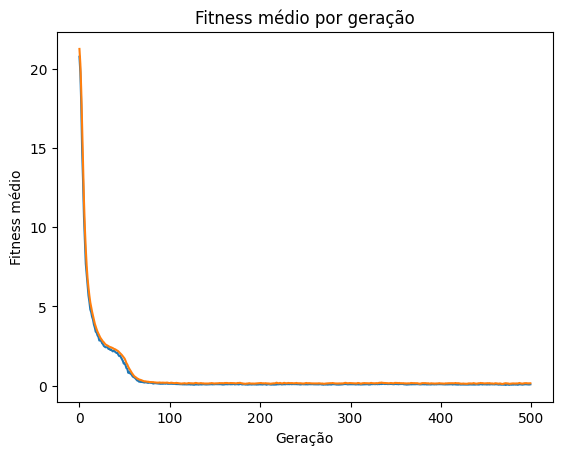

In [74]:
plt.plot(melhor_fitness_grafico)
plt.plot(fitness_medio_grafico)
plt.xlabel('Geração')
plt.ylabel('Fitness médio')
plt.title('Fitness médio por geração')
plt.show()

### Rodando a EE para a função Rastrigin

In [75]:
melhor_solucao, melhor_fitness, melhor_fitness_grafico, fitness_medio_grafico = estrategia_evolutiva(rastrigin)
print(f"Melhor Solução: {melhor_solucao}")
print(f"Melhor Fitness: {melhor_fitness}")

Geração 0: Melhor Fitness = 466.6125173291995, Pior Fitness = 711.9906289966297
Geração 10: Melhor Fitness = 193.2416523010448, Pior Fitness = 231.96467696980335
Geração 20: Melhor Fitness = 70.11467615767276, Pior Fitness = 92.35218046413044
Geração 30: Melhor Fitness = 19.427132864643397, Pior Fitness = 35.09898376289004
Geração 40: Melhor Fitness = 16.129561428941486, Pior Fitness = 25.07512351930336
Geração 50: Melhor Fitness = 12.38443542708751, Pior Fitness = 21.38404881102366
Geração 60: Melhor Fitness = 12.418956940783687, Pior Fitness = 18.505635333301484
Geração 70: Melhor Fitness = 12.727415076613, Pior Fitness = 19.631575115494172
Geração 80: Melhor Fitness = 11.77801087333927, Pior Fitness = 21.16437751715739
Geração 90: Melhor Fitness = 11.555226560027677, Pior Fitness = 19.628525313786668
Geração 100: Melhor Fitness = 11.545072854110913, Pior Fitness = 16.957751306109117
Geração 110: Melhor Fitness = 11.42575586861335, Pior Fitness = 19.156011011539647
Geração 120: Melho

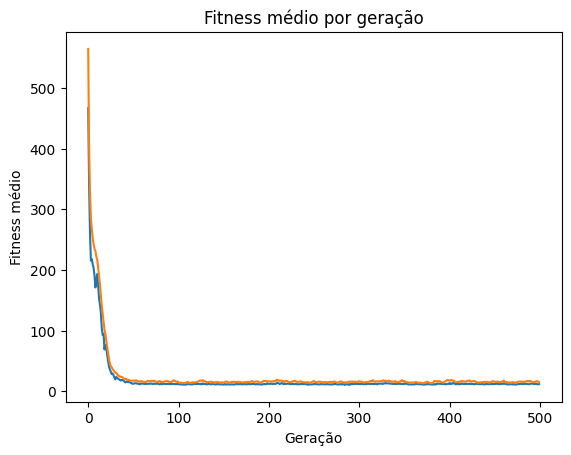

In [76]:
plt.plot(melhor_fitness_grafico)
plt.plot(fitness_medio_grafico)
plt.xlabel('Geração')
plt.ylabel('Fitness médio')
plt.title('Fitness médio por geração')
plt.show()

### Rodando a EE para a função Schwefel

In [77]:
melhor_solucao, melhor_fitness, melhor_fitness_grafico, fitness_medio_grafico = estrategia_evolutiva(schwefel)
print(f"Melhor Solução: {melhor_solucao}")
print(f"Melhor Fitness: {melhor_fitness}")

Geração 0: Melhor Fitness = 8449.424162189116, Pior Fitness = 16110.195433673454
Geração 10: Melhor Fitness = 9629.41961992174, Pior Fitness = 9931.047854829054
Geração 20: Melhor Fitness = 8820.139329969279, Pior Fitness = 8877.854999348898
Geração 30: Melhor Fitness = 3856.337485673912, Pior Fitness = 8232.350231156062
Geração 40: Melhor Fitness = -5.6092299992378685, Pior Fitness = 551.787412908563
Geração 50: Melhor Fitness = -250.49203429932095, Pior Fitness = -126.02183382083058
Geração 60: Melhor Fitness = -3470.2750649151967, Pior Fitness = -3409.916576120111
Geração 70: Melhor Fitness = -3941.098343531741, Pior Fitness = -3864.8115327106043
Geração 80: Melhor Fitness = -4989.806536145299, Pior Fitness = -4106.5186304884355
Geração 90: Melhor Fitness = -7366.4213962677695, Pior Fitness = -6774.256613502535
Geração 100: Melhor Fitness = -7868.367578053088, Pior Fitness = -7632.859890274425
Geração 110: Melhor Fitness = -7991.085758033501, Pior Fitness = -7906.145642235557
Geraçã

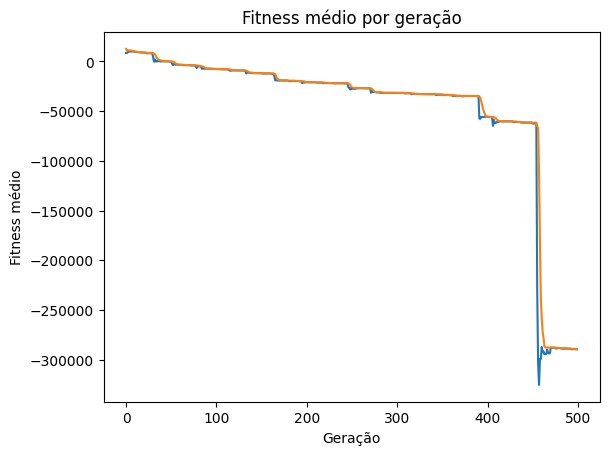

In [78]:
plt.plot(melhor_fitness_grafico)
plt.plot(fitness_medio_grafico)
plt.xlabel('Geração')
plt.ylabel('Fitness médio')
plt.title('Fitness médio por geração')
plt.show()

### Rodando a EE para a função Rosebrock

In [79]:
melhor_solucao, melhor_fitness, melhor_fitness_grafico, fitness_medio_grafico = estrategia_evolutiva(rosenbrock)
print(f"Melhor Solução: {melhor_solucao}")
print(f"Melhor Fitness: {melhor_fitness}")

Geração 0: Melhor Fitness = 6204.129117844274, Pior Fitness = 22399.389854755907
A função zerou!
Melhor Solução: [[ 1.28200631 -1.2202064  -1.08862233 -0.57879025  1.22828777  0.81212063
  -1.06527564 -1.75107029 -1.20487179  0.21335827 -1.67907735 -0.47022455
  -0.51331574 -0.06788623 -0.19390623 -1.98041094  1.03048782 -1.10573655
   0.65487096 -0.62391094 -0.29675681 -0.03397083  1.43796945  1.27387385
  -0.12866281 -0.43628869  0.75550953 -1.7761293   0.00235462  1.00971733]]
Melhor Fitness: 0.0


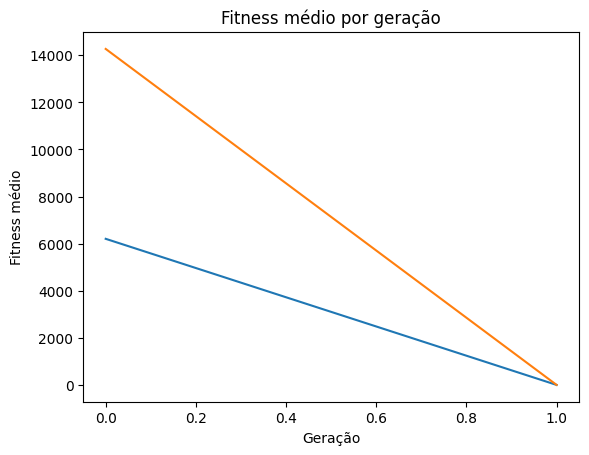

In [80]:
plt.plot(melhor_fitness_grafico)
plt.plot(fitness_medio_grafico)
plt.xlabel('Geração')
plt.ylabel('Fitness médio')
plt.title('Fitness médio por geração')
plt.show()